In [1]:
import os
import pandas as pd
import json
import seaborn as sns
from typing import List

from experiments.interpretation.interpretation_util import (
    ExperimentFiles,
    ExperimentFolders,
)

file_to_compare = ExperimentFiles.ALL_TOOLS_MCP_SEQ

# Base directory setup
notebook_dir = os.path.abspath("")
base_experiment_dir = os.path.join(notebook_dir, "..", "results", "experiments")

dfs = []
all_llm_folders = list(ExperimentFolders)

for folder in all_llm_folders:
    path = os.path.join(base_experiment_dir, folder, file_to_compare)
    try:
        with open(path, "r", encoding="utf-8") as f:
            data = json.load(f)
        df = pd.DataFrame(data)
        dfs.append(df)
    except Exception as e:
        print(f"Failed to load {folder}/{file_to_compare}: {e}")

df = pd.concat(dfs, ignore_index=True)

# Now you can compare/filter by experiment_name
print(df["model_used"].value_counts())

model_used
gpt-4.1             91
o3                  91
gemini-2.0-flash    91
Name: count, dtype: int64


In [2]:
# Sort by experiment_name (CONF-X)
df = df.sort_values(by="model_used")

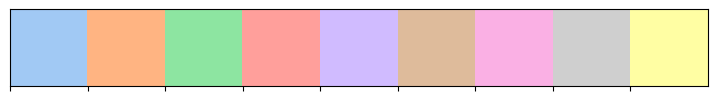

In [3]:
my_palette = sns.color_palette("pastel", 9)

sns.palplot(my_palette)

# Direct Fact Score

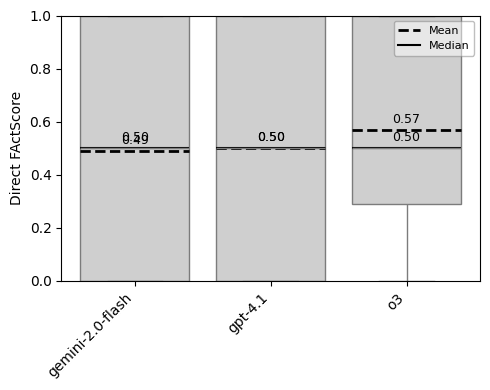

In [4]:
import matplotlib.pyplot as plt

import numpy as np

plt.figure(figsize=(5, 4))

# Draw boxplot and save the axis object
ax = sns.boxplot(
    data=df,
    x="model_used",
    y="fact_score.direct_fact_score",
    color=my_palette[7],
    showfliers=False,
    linewidth=1,
)

# Get the x-tick positions (center of each box)
xticks = ax.get_xticks()
xticklabels = [tick.get_text() for tick in ax.get_xticklabels()]

# Compute statistics
means = df.groupby("model_used")["fact_score.direct_fact_score"].mean()
medians = df.groupby("model_used")["fact_score.direct_fact_score"].median()

# Map experiment names to positions
pos_map = {label: pos for label, pos in zip(xticklabels, xticks)}

# Overlay mean line and median label
for i, (experiment, pos) in enumerate(pos_map.items()):
    mean_val = means.get(experiment)
    median_val = medians.get(experiment)

    if mean_val is not None:
        # Mean (red dashed line)
        plt.hlines(
            mean_val,
            pos - 0.40,
            pos + 0.40,
            colors="black",
            linestyles="--",
            linewidth=2,
            label="Mean" if i == 0 else "",  # Label only once
        )
        plt.text(
            pos,
            mean_val + 0.015,
            f"{mean_val:.2f}",
            color="black",
            va="bottom",
            fontsize=9,
            ha="center",
        )

    if median_val is not None:
        # Median label (black)
        plt.hlines(
            median_val,
            pos - 0.40,
            pos + 0.40,
            colors="black",
            linestyles="-",
            linewidth=1.5,
            label="Median" if i == 0 else "",  # Label only once
        )
        plt.text(
            pos,
            median_val + 0.015,
            f"{median_val:.2f}",
            color="black",
            va="bottom",
            fontsize=9,
            ha="center",
        )

# Final formatting
plt.xlabel("")
plt.ylabel("Direct FActScore")
plt.ylim(0, 1)
plt.xticks(rotation=45, ha="right")

# Inline legend inside top-right of plot with transparent background
legend = ax.legend(
    handles=[
        plt.Line2D([0], [0], color="black", linestyle="--", linewidth=2, label="Mean"),
        plt.Line2D(
            [0], [0], color="black", linestyle="-", linewidth=1.5, label="Median"
        ),
    ],
    loc="upper right",
    fontsize=8,
    frameon=True,
)

# Customize legend box appearance
legend.get_frame().set_facecolor("white")
legend.get_frame().set_alpha(0.5)  # Slight transparency
legend.get_frame().set_edgecolor("gray")

plt.tight_layout()
plt.show()

# Agent as a judge outcome

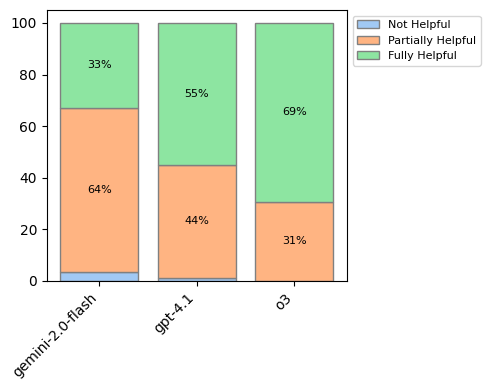

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare the data
stacked_data = (
    df.groupby(["model_used", "agent_judge_outcome"]).size().unstack(fill_value=0)
)

# Desired outcome stacking order
desired_order = ["Not Helpful", "Partially Helpful", "Fully Helpful"]
stacked_data = stacked_data[desired_order]

# Convert to percentages row-wise
stacked_percent = stacked_data.div(stacked_data.sum(axis=1), axis=0) * 100

# Plot
plt.figure(figsize=(5, 4))
bottom = [0] * len(stacked_data)

for idx, outcome in enumerate(desired_order):
    values = stacked_percent[outcome].values
    bars = plt.bar(
        stacked_percent.index,
        values,
        bottom=bottom,
        label=outcome,
        color=my_palette[idx],
        edgecolor="gray",
    )

    # Annotate with percent labels (skip small segments)
    for i, (val, btm) in enumerate(zip(values, bottom)):
        if val >= 5:  # Only annotate if >= 5% to avoid clutter
            plt.text(
                i,
                btm + val / 2,
                f"{val:.0f}%",
                ha="center",
                va="center",
                fontsize=8,
                color="black",
            )

    bottom = [btm + val for btm, val in zip(bottom, values)]

# Labels and legend
plt.xticks(rotation=45, ha="right")
plt.legend(
    bbox_to_anchor=(1, 1),
    loc="best",
    fontsize=8,
)
plt.tight_layout()
plt.show()

# Token Consumption

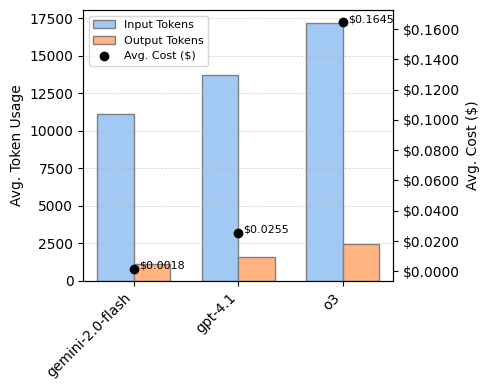

In [28]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.patches import Patch
import seaborn as sns

# -- Preprocess as before --

# Token usage per model
token_cols = [
    "tokens_consumed.input_tokens",
    "tokens_consumed.output_tokens",
]
mean_token_usage = df.groupby("model_used")[token_cols].mean().reset_index()

# Cost per model
from experiments.interpretation.interpretation_util import ModelPricing

grouped = df.groupby("model_used")
agent_costs = {
    model: (
        (group["tokens_consumed.input_tokens"].mean() / 1000)
        * ModelPricing[model]["input"]
        + (group["tokens_consumed.output_tokens"].mean() / 1000)
        * ModelPricing[model]["output"]
    )
    for model, group in grouped
}

# -- Create figure --
fig, ax1 = plt.subplots(figsize=(5, 4))

# Plot token usage (stacked bars: input + output)
x = mean_token_usage["model_used"]
input_tokens = mean_token_usage["tokens_consumed.input_tokens"]
output_tokens = mean_token_usage["tokens_consumed.output_tokens"]

bar_width = 0.35
x = mean_token_usage["model_used"]
x_pos = range(len(x))

bar1 = ax1.bar(
    [i - bar_width / 2 for i in x_pos],
    input_tokens,
    width=bar_width,
    color=my_palette[0],
    edgecolor="gray",
    label="Input Tokens",
)

bar2 = ax1.bar(
    [i + bar_width / 2 for i in x_pos],
    output_tokens,
    width=bar_width,
    color=my_palette[1],
    edgecolor="gray",
    label="Output Tokens",
)

ax1.set_xticks(x_pos)
ax1.set_xticklabels(x, rotation=45, ha="right")

ax1.set_ylabel("Avg. Token Usage")
ax1.set_xticks(range(len(x)))
ax1.set_xticklabels(x, rotation=45, ha="right")
ax1.grid(axis="y", linestyle="--", linewidth=0.5, alpha=0.6)

# Plot cost using a secondary y-axis
ax2 = ax1.twinx()
costs = [agent_costs[model] for model in x]
line = ax2.scatter(
    range(len(x)),
    costs,
    color="black",
    marker="o",
    linestyle="-",
    label="Avg. Cost ($)",
)

ax2.set_ylabel("Avg. Cost ($)")
ax2.yaxis.set_major_formatter(mtick.StrMethodFormatter("${x:,.4f}"))

# Add cost labels above each point
for i, cost in enumerate(costs):
    ax2.annotate(
        f"${cost:.4f}",
        (i, cost),
        textcoords="offset points",
        xytext=(20, 0),
        ha="center",
        fontsize=8,
        color="black",
    )

# Legend (combine handles from both axes)
token_legend = [
    Patch(facecolor=my_palette[0], edgecolor="gray", label="Input Tokens"),
    Patch(facecolor=my_palette[1], edgecolor="gray", label="Output Tokens"),
]

all_handles = token_legend + [line]
ax1.legend(handles=all_handles, loc="upper left", fontsize=8, frameon=True)

# Final layout
plt.tight_layout()
plt.show()

# BERT Score

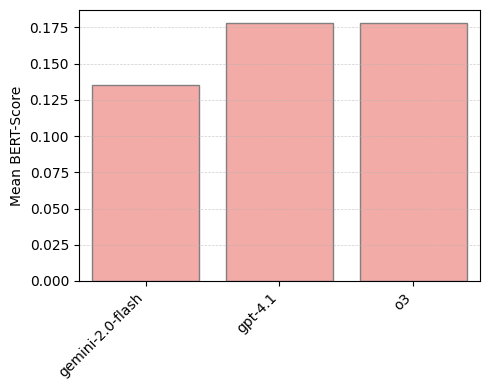

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get the order from df
experiment_order = df["model_used"].unique()

# Compute mean BERT score per experiment
mean_bert = df.groupby("model_used")["bert_score"].mean().reset_index()

# Plot
plt.figure(figsize=(5, 4))
ax = sns.barplot(
    data=mean_bert,
    x="model_used",
    y="bert_score",
    order=experiment_order,
    color=my_palette[3],
    edgecolor="gray",
)

# Grid for guidance
plt.grid(True, which="major", axis="y", linestyle="--", linewidth=0.5, alpha=0.6)

# Formatting
plt.xlabel("")
plt.ylabel("Mean BERT-Score")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Tool Calls

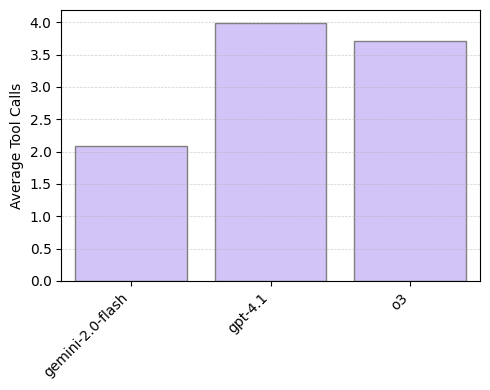

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get the order from df
experiment_order = df["model_used"].unique()

# Compute mean tool calls per experiment
mean_tools = df.groupby("model_used")["tool_calls_count"].mean().reset_index()

# Plot
plt.figure(figsize=(5, 4))
ax = sns.barplot(
    data=mean_tools,
    x="model_used",
    y="tool_calls_count",
    order=experiment_order,
    color=my_palette[4],
    edgecolor="gray",
)

# Grid for guidance
plt.grid(True, which="major", axis="y", linestyle="--", linewidth=0.5, alpha=0.6)

# Formatting
plt.xlabel("")
plt.ylabel("Average Tool Calls")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Time Consumed

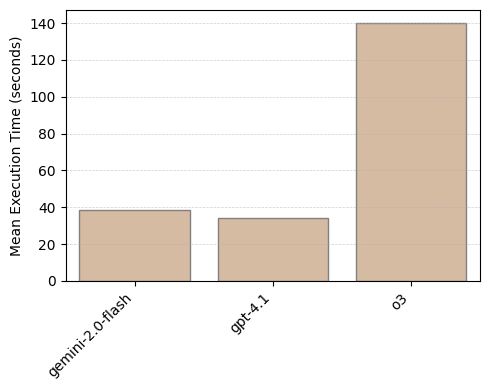

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Group by configuration (experiment_name), compute mean execution time
grouped = df.groupby("model_used")["excecution_time_seconds"].mean().reset_index()


# Plot
plt.figure(figsize=(5, 4))
sns.barplot(
    data=grouped,
    x="model_used",
    y="excecution_time_seconds",
    color=my_palette[5],
    edgecolor="gray",
)

# Grid for guidance
plt.grid(True, which="major", axis="y", linestyle="--", linewidth=0.5, alpha=0.6)

plt.xticks(rotation=45, ha="right")
plt.ylabel("Mean Execution Time (seconds)")
plt.xlabel("")
plt.tight_layout()
plt.show()